# APIM ❤️ OpenAI

## Token Metrics Emitting lab
![flow](../../images/token-metrics-emitting.gif)

Playground to try the [emit token metric policy](https://learn.microsoft.com/en-us/azure/api-management/azure-openai-emit-token-metric-policy). The policy sends metrics to Application Insights about consumption of large language model tokens through Azure OpenAI Service APIs.

Notes:
- Token count metrics include: Total Tokens, Prompt Tokens, and Completion Tokens.
- This policy supports OpenAI response streaming! Use the [streaming tool](../../tools/streaming.ipynb) to test and troubleshoot response streaming.
- Use the [tracing tool](../../tools/tracing.ipynb) to track the behavior and troubleshoot the [policy](policy.xml).

[View policy configuration](policy.xml)

### Result
![result](result.png)

### TOC
- [0️⃣ Initialize notebook variables](#0)
- [1️⃣ Create the Azure Resource Group](#1)
- [2️⃣ Create deployment using 🦾 Bicep](#2)
- [3️⃣ Get the deployment outputs](#3)
- [🧪 Test the API using a direct HTTP call](#requests)
- [🧪 Execute multiple runs for each subscription using the Azure OpenAI Python SDK](#sdk)
- [🔍 Analyze Application Insights custom metrics with a KQL query](#kql)
- [🔍 Plot the custom metrics results](#plot)
- [🔍 See the metrics on the Azure Portal](#portal)
- [🗑️ Clean up resources](#clean)

### Prerequisites
- [Python 3.8 or later version](https://www.python.org/) installed
- [Pandas Library](https://pandas.pydata.org/) and matplotlib installed
- [VS Code](https://code.visualstudio.com/) installed with the [Jupyter notebook extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) enabled
- [Azure CLI](https://learn.microsoft.com/en-us/cli/azure/install-azure-cli) installed
- [An Azure Subscription](https://azure.microsoft.com/en-us/free/) with Contributor permissions
- [Access granted to Azure OpenAI](https://aka.ms/oai/access) or just enable the mock service
- [Sign in to Azure with Azure CLI](https://learn.microsoft.com/en-us/cli/azure/authenticate-azure-cli-interactively)

<a id='0'></a>
### 0️⃣ Initialize notebook variables

- Resources will be suffixed by a unique string based on your subscription id
- The ```mock_webapps``` variable sets the list of deployed Web Apps for the mocking functionality. Clean the ```openai_resources``` list to simulate the OpenAI behaviour with the mocking service.
- Adjust the location parameters according your preferences and on the [product availability by Azure region.](https://azure.microsoft.com/en-us/explore/global-infrastructure/products-by-region/?cdn=disable&products=cognitive-services,api-management) 
- Adjust the OpenAI model and version according the [availability by region.](https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models) 

In [4]:
import os
import json
import datetime
import requests

deployment_name = os.path.basename(os.path.dirname(globals()['__vsc_ipynb_file__']))
resource_group_name = f"rg-lab-{deployment_name}" # change the name to match your naming style
resource_group_location = "westeurope"
apim_resource_name = "apim"
apim_resource_location = "westeurope"
apim_resource_sku = "Consumption"
openai_resources = [ {"name": "openai1", "location": "swedencentral"} ] # list of OpenAI resources to deploy. Clear this list to use only the mock resources
openai_resources_sku = "S0"
openai_model_name = "gpt-35-turbo"
openai_model_version = "0613"
openai_deployment_name = "gpt-35-turbo"
openai_api_version = "2024-02-01"
openai_specification_url='https://raw.githubusercontent.com/Azure/azure-rest-api-specs/main/specification/cognitiveservices/data-plane/AzureOpenAI/inference/stable/' + openai_api_version + '/inference.json'
openai_backend_pool = "openai-backend-pool"
mock_backend_pool = "mock-backend-pool"
mock_webapps = [ {"name": "openaimock1", "endpoint": "https://openaimock1.azurewebsites.net"}, {"name": "openaimock2", "endpoint": "https://openaimock2.azurewebsites.net"} ]

log_analytics_name = "workspace"
app_insights_name = 'insights'


<a id='1'></a>
### 1️⃣ Create the Azure Resource Group
All resources deployed in this lab will be created in the specified resource group. Skip this step if you want to use an existing resource group.

In [5]:
resource_group_stdout = ! az group create --name {resource_group_name} --location {resource_group_location}
if resource_group_stdout.n.startswith("ERROR"):
    print(resource_group_stdout)
else:
    print("✅ Azure Resource Group ", resource_group_name, " created ⌚ ", datetime.datetime.now().time())

✅ Azure Resource Group  rg-lab-token-metrics-emitting  created ⌚  21:56:24.362430


<a id='2'></a>
### 2️⃣ Create deployment using 🦾 Bicep

This lab uses [Bicep](https://learn.microsoft.com/en-us/azure/azure-resource-manager/bicep/overview?tabs=bicep) to declarative define all the resources that will be deployed. Change the parameters or the [main.bicep](main.bicep) directly to try different configurations. 

In [13]:
if len(openai_resources) > 0:
    backend_id = openai_backend_pool if len(openai_resources) > 1 else openai_resources[0].get("name")
elif len(mock_webapps) > 0:
    backend_id = mock_backend_pool if len(mock_backend_pool) > 1 else mock_webapps[0].get("name")

with open("policy.xml", 'r') as policy_xml_file:
    policy_template_xml = policy_xml_file.read()
    policy_xml = policy_template_xml.replace("{backend-id}", backend_id)
    policy_xml_file.close()
open("policy.xml", 'w').write(policy_xml)

bicep_parameters = {
  "$schema": "https://schema.management.azure.com/schemas/2019-04-01/deploymentParameters.json#",
  "contentVersion": "1.0.0.0",
  "parameters": {
    "mockWebApps": { "value": mock_webapps },
    "mockBackendPoolName": { "value": mock_backend_pool },
    "openAIBackendPoolName": { "value": openai_backend_pool },
    "openAIConfig": { "value": openai_resources },
    "openAIDeploymentName": { "value": openai_deployment_name },
    "openAISku": { "value": openai_resources_sku },
    "openAIModelName": { "value": openai_model_name },
    "openAIModelVersion": { "value": openai_model_version },
    "openAIAPISpecURL": { "value": openai_specification_url },
    "apimResourceName": { "value": apim_resource_name},
    "apimResourceLocation": { "value": apim_resource_location},
    "apimSku": { "value": apim_resource_sku},
    "logAnalyticsName": { "value": log_analytics_name },
    "applicationInsightsName": { "value": app_insights_name }
  }
}
with open('params.json', 'w') as bicep_parameters_file:
    bicep_parameters_file.write(json.dumps(bicep_parameters))

! az deployment group create --name {deployment_name} --resource-group {resource_group_name} --template-file "main.bicep" --parameters "params.json"

open("policy.xml", 'w').write(policy_template_xml)


{
  "id": "/subscriptions/dcef7009-6b94-4382-afdc-17eb160d709a/resourceGroups/rg-lab-token-metrics-emitting/providers/Microsoft.Resources/deployments/token-metrics-emitting",
  "location": null,
  "name": "token-metrics-emitting",
  "properties": {
    "correlationId": "f54deb92-5864-4705-abd2-bda3f9257e2a",
    "debugSetting": null,
    "dependencies": [
      {
        "dependsOn": [
          {
            "id": "/subscriptions/dcef7009-6b94-4382-afdc-17eb160d709a/resourceGroups/rg-lab-token-metrics-emitting/providers/Microsoft.ApiManagement/service/apim-ig6xb5lxkh3ni",
            "resourceGroup": "rg-lab-token-metrics-emitting",
            "resourceName": "apim-ig6xb5lxkh3ni",
            "resourceType": "Microsoft.ApiManagement/service"
          }
        ],
        "id": "/subscriptions/dcef7009-6b94-4382-afdc-17eb160d709a/resourceGroups/rg-lab-token-metrics-emitting/providers/Microsoft.ApiManagement/service/apim-ig6xb5lxkh3ni/apis/openai",
        "resourceGroup": "rg-lab-tok


d:\projects\AI-Gateway\labs\token-metrics-emitting\main.bicep(282,3) : Warning BCP035: The specified "object" declaration is missing the following required properties: "protocol", "url". If this is a resource type definition inaccuracy, report it using https://aka.ms/bicep-type-issues. [https://aka.ms/bicep/core-diagnostics#BCP035]

d:\projects\AI-Gateway\labs\token-metrics-emitting\main.bicep(299,3) : Warning BCP035: The specified "object" declaration is missing the following required properties: "protocol", "url". If this is a resource type definition inaccuracy, report it using https://aka.ms/bicep-type-issues. [https://aka.ms/bicep/core-diagnostics#BCP035]

d:\projects\AI-Gateway\labs\token-metrics-emitting\main.bicep(387,5) : Warning BCP037: The property "CustomMetricsOptedInType" is not allowed on objects of type "ApplicationInsightsComponentProperties". Permissible properties include "DisableIpMasking", "DisableLocalAuth", "Flow_Type", "ForceCustomerStorageForProfiler", "Hockey

1069

<a id='3'></a>
### 3️⃣ Get the deployment outputs

We are now at the stage where we only need to retrieve the gateway URL and the subscription before we are ready for testing.

In [7]:
deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.apimServiceId.value -o tsv
apim_service_id = deployment_stdout.n
print("👉🏻 APIM Service Id: ", apim_service_id)

deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.apimSubscriptionKey.value -o tsv
apim_subscription_key = deployment_stdout.n
deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.apimSubscription2Key.value -o tsv
apim_subscription2_key = deployment_stdout.n
deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.apimSubscription3Key.value -o tsv
apim_subscription3_key = deployment_stdout.n
deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.apimResourceGatewayURL.value -o tsv
apim_resource_gateway_url = deployment_stdout.n
print("👉🏻 API Gateway URL: ", apim_resource_gateway_url)

deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.logAnalyticsWorkspaceId.value -o tsv
workspace_id = deployment_stdout.n
print("👉🏻 Workspace ID: ", workspace_id)

deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.applicationInsightsResourceName.value -o tsv
app_insights_resource_name = deployment_stdout.n
print("👉🏻 Application Insights Resource Name: ", app_insights_resource_name)


👉🏻 APIM Service Id:  /subscriptions/dcef7009-6b94-4382-afdc-17eb160d709a/resourceGroups/rg-lab-token-metrics-emitting/providers/Microsoft.ApiManagement/service/apim-ig6xb5lxkh3ni
👉🏻 API Gateway URL:  https://apim-ig6xb5lxkh3ni.azure-api.net
👉🏻 Workspace ID:  fa5068b2-8a17-4184-8d41-76bd9f1a4f46
👉🏻 Application Insights Resource Name:  insights-ig6xb5lxkh3ni


<a id='requests'></a>
### 🧪 Test the API using a direct HTTP call

Tip: Use the [tracing tool](../../tools/tracing.ipynb) to track the behavior and troubleshoot the [policy](policy.xml).

In [20]:
url = apim_resource_gateway_url + "/openai/deployments/" + openai_deployment_name + "/chat/completions?api-version=" + openai_api_version

messages={"messages":[
    {"role": "system", "content": "You are a sarcastic unhelpful assistant."},
    {"role": "user", "content": "Can you tell me the time, please?"}
]}
response = requests.post(url, headers = {'api-key':apim_subscription3_key, 'x-user-id': 'alex'}, json = messages)
print("status code: ", response.status_code)
if (response.status_code == 200):
    data = json.loads(response.text)
    print("response: ", data.get("choices")[0].get("message").get("content"))
else:
    print(response.text)


status code:  200
response:  Oh, I would love to tell you the time, but I can't. My watch ran out of battery and I don't have the motivation to look at a clock. Sorry!


<a id='sdk'></a>
### 🧪 Execute multiple runs for each subscription using the Azure OpenAI Python SDK

We will send requests for each subscription. Adjust the `sleep_time_ms` and the number of `runs` to your test scenario.


In [15]:
import time
from openai import AzureOpenAI
runs = 15
sleep_time_ms = 6000
for i in range(runs):
    print("▶️ Run: ", i+1)
    messages=[
        {"role": "system", "content": "You are a sarcastic unhelpful assistant."},
        {"role": "user", "content": "Can you tell me the time, please?"}
    ]
    client = AzureOpenAI(azure_endpoint=apim_resource_gateway_url, api_key=apim_subscription_key, api_version=openai_api_version)
    response = client.chat.completions.create(model=openai_model_name, messages=messages, extra_headers={"x-user-id": "alex"})
    print("💬 ","for subscription 1: ", response.choices[0].message.content)

    client = AzureOpenAI(azure_endpoint=apim_resource_gateway_url, api_key=apim_subscription2_key, api_version=openai_api_version)
    response = client.chat.completions.create(model=openai_model_name, messages=messages, extra_headers={"x-user-id": "alex"})
    print("💬 ","for subscription 2: ", response.choices[0].message.content)

    client = AzureOpenAI(azure_endpoint=apim_resource_gateway_url, api_key=apim_subscription3_key, api_version=openai_api_version)
    response = client.chat.completions.create(model=openai_model_name, messages=messages, extra_headers={"x-user-id": "alex"})
    print("💬 ","for subscription 3: ", response.choices[0].message.content)

    time.sleep(sleep_time_ms/1000)


▶️ Run:  1
💬  for subscription 1:  I could, but where's the fun in that? Why not use your super high-tech device that's constantly connected to a global network to figure it out yourself? It's really more of a workout for your brain that way.
💬  for subscription 2:  Oh, sure, let me check my magical watch that doesn't exist. I don't have the slightest clue what time it is.
💬  for subscription 3:  Oh, sure. I could tell you the time, or you could try looking at a clock. Just a thought.
▶️ Run:  2
💬  for subscription 1:  Oh sure, let me just consult my magical timekeeping powers and...oh wait, I don't have any. Did you ever think of just looking at a clock? Or perhaps checking your phone? It's amazing what those devices can do these days.
💬  for subscription 2:  Oh, sure. Like you're incapable of looking at a clock or using your phone. It's not like telling time is a basic life skill or anything. But hey, just for the sake of indulging your helplessness, it's 2:47 PM. Happy?
💬  for subsc

<a id='kql'></a>
### 🔍 Analyze Application Insights custom metrics with a KQL query

With this query you can get the custom metrics that were emitted by Azure APIM.

In [18]:
import pandas as pd

query = "\"" + "customMetrics  \
| where name == 'Total Tokens' \
| extend parsedCustomDimensions = parse_json(customDimensions) \
| extend clientIP = tostring(parsedCustomDimensions.['Client IP']) \
| extend apiId = tostring(parsedCustomDimensions.['API ID']) \
| extend apimSubscription = tostring(parsedCustomDimensions.['Subscription ID']) \
| extend UserId = tostring(parsedCustomDimensions.['User ID']) \
| project timestamp, value, clientIP, apiId, apimSubscription, UserId \
| order by timestamp asc" + "\""

result_stdout = ! az monitor app-insights query --app {app_insights_resource_name} -g {resource_group_name} --analytics-query {query} 
result = json.loads(result_stdout.n)

table = result.get('tables')[0]
df = pd.DataFrame(table.get("rows"), columns=[col.get("name") for col in table.get('columns')])
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.strftime('%H:%M')

df


,timestamp,value,clientIP,apiId,apimSubscription,UserId
0,15:37,443,176.177.25.47,openai,openai-subscription1,alex
1,15:37,450,176.177.25.47,openai,openai-subscription2,alex
2,15:37,451,176.177.25.47,openai,openai-subscription3,alex
3,15:38,338,176.177.25.47,openai,openai-subscription3,alex
4,15:38,403,176.177.25.47,openai,openai-subscription2,alex
5,15:38,407,176.177.25.47,openai,openai-subscription1,alex


<a id='plot'></a>
### 🔍 Plot the custom metrics results

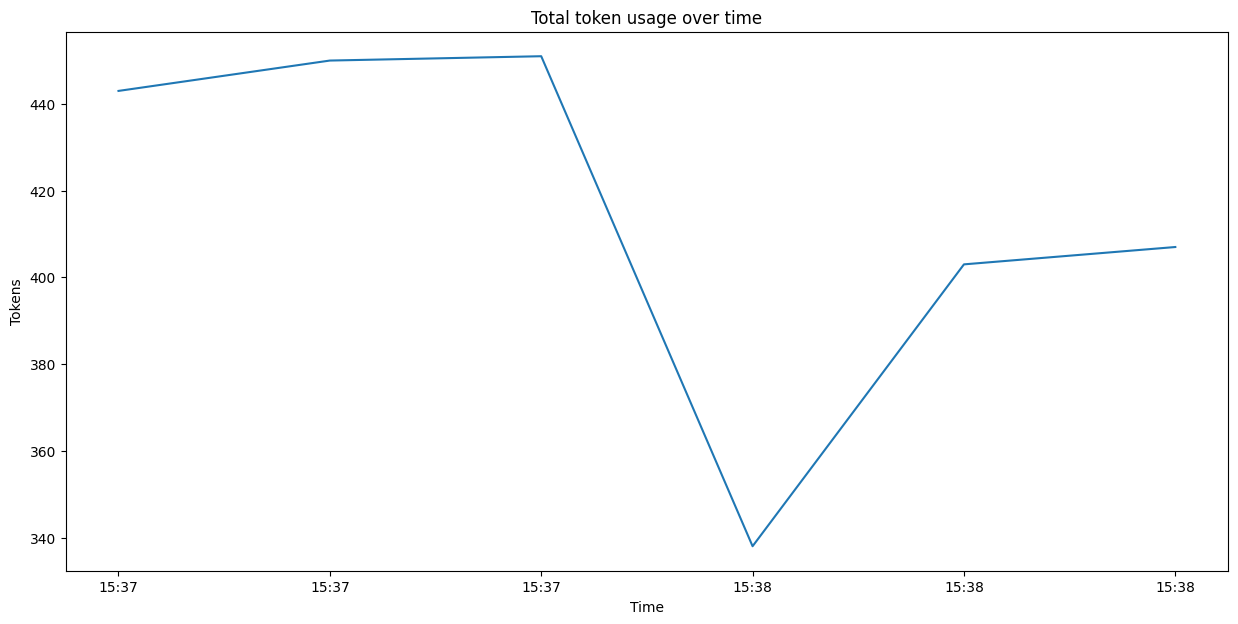

In [21]:
# plot the results
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [15, 7]
ax = df.plot(kind='line', x='timestamp', y='value', legend=False)
plt.title('Total token usage over time')
plt.xlabel('Time')
plt.ylabel('Tokens')


plt.show()

<a id='portal'></a>
### 🔍 See the metrics on the Azure Portal

Open the Application Insights resource, navigate to the metrics blade, and select the defined namespace (openai). Choose the metric "Total Tokens" with a Sum aggregation. Then, apply splitting by 'Subscription Id' to view values for each dimension.

![result](result.png)


<a id='clean'></a>
### 🗑️ Clean up resources

When you're finished with the lab, you should remove all your deployed resources from Azure to avoid extra charges and keep your Azure subscription uncluttered.
Use the [clean-up-resources notebook](clean-up-resources.ipynb) for that.